## Pumpkin Varieties and Color

Load up required libraries and dataset. Convert the data to a dataframe containing a subset of the data: 

Let's look at the relationship between color and variety

In [38]:
import pandas as pd
import numpy as np

full_pumpkins = pd.read_csv('../data/US-pumpkins.csv')
full_pumpkins.head()

,City Name,Type,Package,Variety,Sub Variety,Grade,Date,Low Price,High Price,Mostly Low,...,Unit of Sale,Quality,Condition,Appearance,Storage,Crop,Repack,Trans Mode,Unnamed: 24,Unnamed: 25
0,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,4/29/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
1,BALTIMORE,NaN,24 inch bins,NaN,NaN,NaN,5/6/17,270.0,280.0,270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,E,NaN,NaN,NaN
2,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
3,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,9/24/16,160.0,160.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN
4,BALTIMORE,NaN,24 inch bins,HOWDEN TYPE,NaN,NaN,11/5/16,90.0,100.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN


In [39]:
columns_to_select = ['City Name','Package','Variety', 'Origin','Item Size', 'Color']
pumpkins = full_pumpkins.loc[:, columns_to_select]

pumpkins.dropna(inplace=True)
# pumpkins.info()

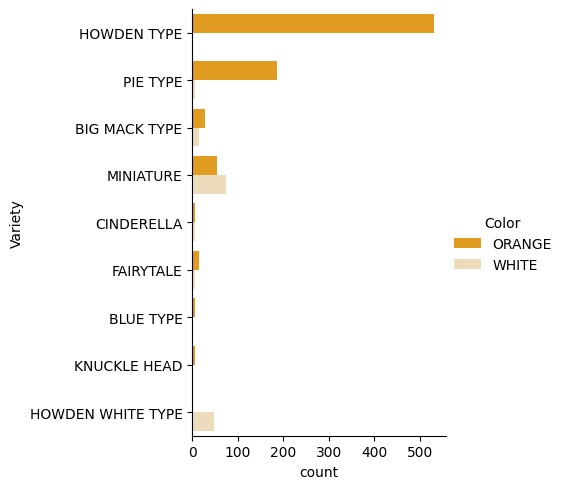

In [40]:
import seaborn as sns

palette = {
'ORANGE': 'orange',
'WHITE': 'wheat',
}

sns.catplot(
data=pumpkins, y="Variety", hue="Color", kind="count",
palette=palette, 
)

In [41]:
from sklearn.preprocessing import OrdinalEncoder

item_size_categories = [['sml', 'med', 'med-lge', 'lge', 'xlge', 'jbo', 'exjbo']]
ordinal_features = ['Item Size']
ordinal_encoder = OrdinalEncoder(categories=item_size_categories)

from sklearn.preprocessing import OneHotEncoder

categorical_features = ['City Name', 'Package', 'Variety', 'Origin']
categorical_encoder = OneHotEncoder(sparse_output=False)

from sklearn.compose import ColumnTransformer
    
ct = ColumnTransformer(transformers=[
    ('ord', ordinal_encoder, ordinal_features),
    ('cat', categorical_encoder, categorical_features)
    ])
    
ct.set_output(transform='pandas')
encoded_features = ct.fit_transform(pumpkins)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
encoded_label = label_encoder.fit_transform(pumpkins['Color'])

encoded_pumpkins = encoded_features.assign(Color=encoded_label)

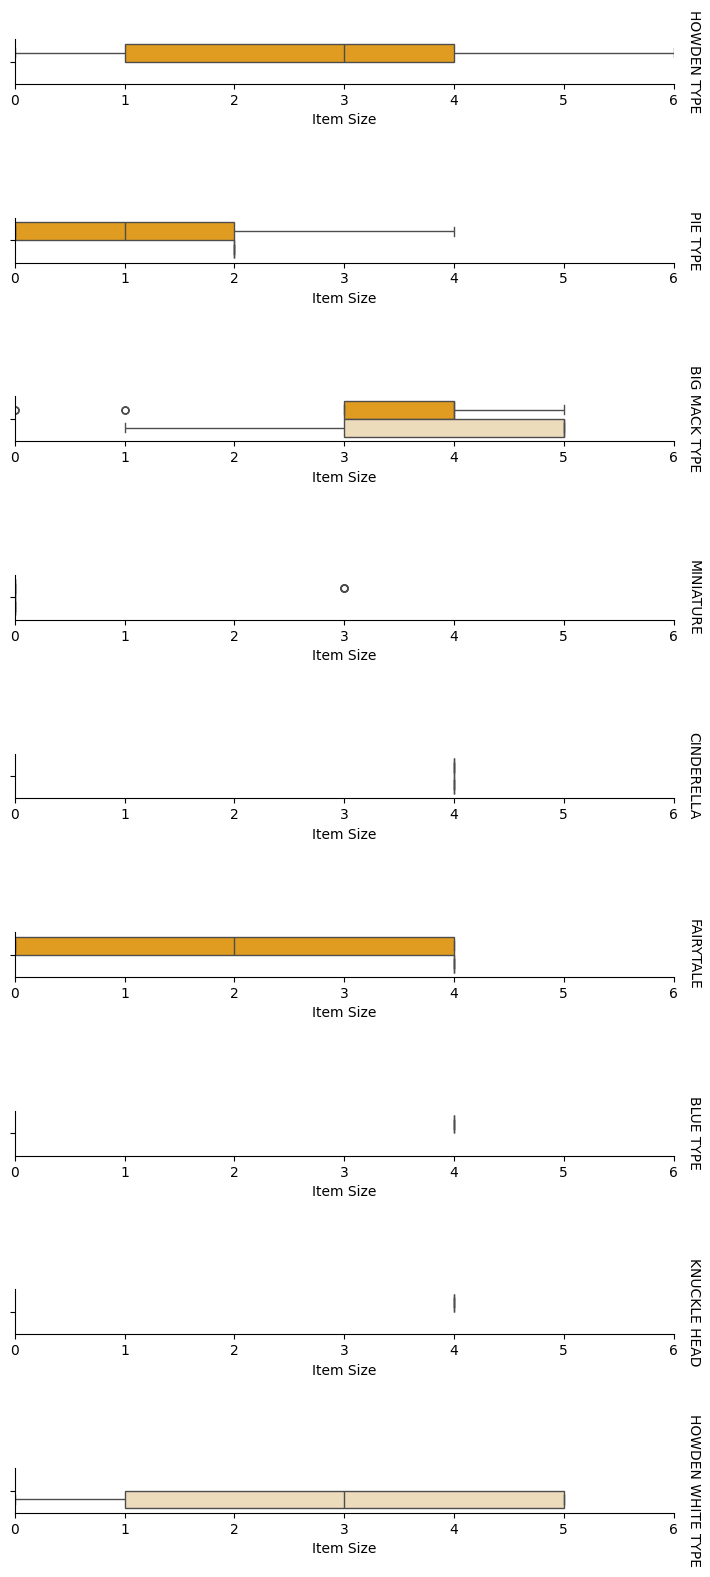

In [42]:
palette = {
'ORANGE': 'orange',
'WHITE': 'wheat'
}
pumpkins['Item Size'] = encoded_pumpkins['ord__Item Size']

g = sns.catplot(
    data=pumpkins,
    x="Item Size", hue="Color", row='Variety',
    kind="box", orient="h",
    sharex=False, margin_titles=True,
    height=1.8, aspect=4, palette=palette, 
    legend = False
    )
g.set(xlabel="Item Size", ylabel="").set(xlim=(0,6))
g.set_titles(row_template="{row_name}")

/Users/vgeorgieva/ML-For-Beginners/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 63.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/vgeorgieva/ML-For-Beginners/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 21.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<Axes: xlabel='Color', ylabel='ord__Item Size'>

/Users/vgeorgieva/ML-For-Beginners/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 79.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/vgeorgieva/ML-For-Beginners/.venv/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 35.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


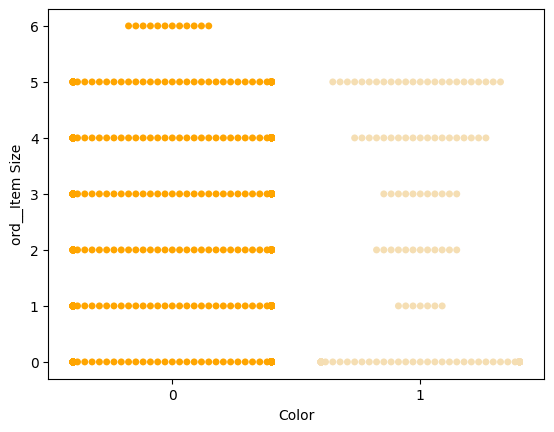

In [43]:
palette = {
0: 'orange',
1: 'wheat'
}

sns.swarmplot(x= "Color", hue="Color", y="ord__Item Size", data=encoded_pumpkins, palette=palette, legend = False)

In [44]:
from sklearn.model_selection import train_test_split

X = encoded_pumpkins[encoded_pumpkins.columns.difference(['Color'])]
y = encoded_pumpkins['Color']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

from sklearn.metrics import f1_score, classification_report 
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))
# print('Predicted labels: ', predictions)
print('F1-score: ', f1_score(y_test, predictions))

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       166
           1       0.85      0.67      0.75        33

    accuracy                           0.92       199
   macro avg       0.89      0.82      0.85       199
weighted avg       0.92      0.92      0.92       199

F1-score:  0.7457627118644068


array([[162,   4],
       [ 11,  22]])

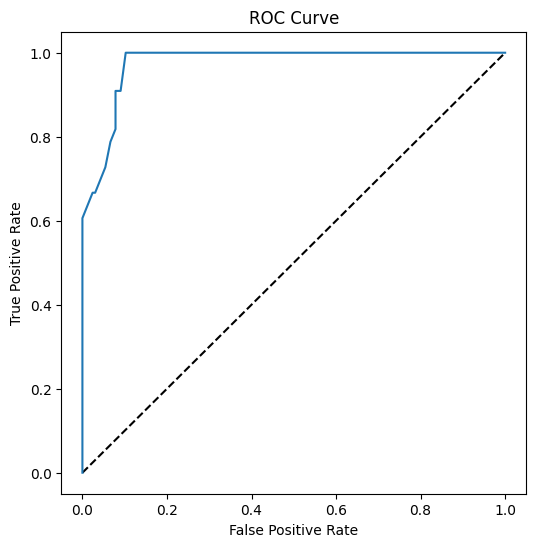

In [45]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

y_scores = model.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])

fig = plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [46]:
auc = roc_auc_score(y_test,y_scores[:,1])
print(auc)

0.9749908725812341
